In [1]:
import pandas as pd 
import plotly.express as px
import pandas as pd 
from darts import TimeSeries
import logging
from darts.metrics import mae, mse
from datetime import datetime
import pytz
from darts.models import Prophet,LightGBMModel
from darts.utils.timeseries_generation import datetime_attribute_timeseries
import pandas as pd
from darts.timeseries import TimeSeries
from darts.utils.missing_values import fill_missing_values
from darts.metrics.metrics import mse
from darts.dataprocessing.transformers import Scaler
import os
from data_aggregation_engine import fetch_CO2_data, fetch_day_ahead_prices
import matplotlib.pyplot as plt 
import scienceplots
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt




plt.style.use('ieee')
%load_ext autoreload
%autoreload 2

The StatsForecast module could not be imported. To enable support for the AutoARIMA, AutoETS and Croston models, please consider installing it.


In [2]:
root_folder = '/home/alqua/data/data_vdfs/'
data = pd.read_csv(root_folder + 'sym_data/inflow_and_weather_data.csv')

In [3]:
data["precip_past1min"] = gaussian_filter1d(data["precip_past1min"],5)

In [4]:
start_date="2023-02-01" 
end_date="2023-02-28"

data = data[(data['time'] >= start_date) & (data['time'] <= end_date)]


In [5]:
data["time"] = pd.to_datetime(data["time"])

In [6]:
data = data.set_index("time")
data["inflow"] = data["inflow"].ewm(alpha=0.3).mean()

In [7]:
def to_darts_timeseries(data: pd.DataFrame, training_cutoff,  filling_nan = True, train_test_split = True, scale=False):
    series = TimeSeries.from_dataframe(data, freq="1H")
    ts_series = fill_missing_values(series)
    
    if filling_nan and train_test_split and scale:
        print("scaling")
        transformer = Scaler()
        ts_series = transformer.fit_transform(ts_series)
        train_df, test_df = ts_series.split_after(training_cutoff)
        return transformer, ts_series, train_df, test_df
    
    elif filling_nan and train_test_split and not scale:
        train_df, test_df = ts_series.split_after(training_cutoff)
        return ts_series, train_df, test_df
    
    elif filling_nan and not train_test_split and not scale:
        ts_series = fill_missing_values(series)
        return ts_series

In [8]:
training_cutoff = pd.Timestamp("20230210")
ts_series, train_df, test_df = to_darts_timeseries(data, training_cutoff,  train_test_split=True, scale=False)

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.
/home/alqua/anaconda3/envs/opt_env/lib/python3.12/site-packages/darts/timeseries.py:5248: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_time_index = resampled_time_index.asfreq(freq)


In [9]:
def generate_covariates(ts_series):
    year_covariates   = datetime_attribute_timeseries(ts_series, attribute="year", one_hot=False)
    month_covariates  = datetime_attribute_timeseries(ts_series, attribute="month", one_hot=False)
    day_covariates    = datetime_attribute_timeseries(ts_series, attribute="day", one_hot=False)
    hour_covariates   = datetime_attribute_timeseries(ts_series, attribute="hour", one_hot=False)
    precip_covariates = ts_series["precip_past1min"]
    wind_covariates   = ts_series["wind_speed"]
    humidity_covariates = ts_series["humidity"]

    future_cov =  precip_covariates.stack(wind_covariates).stack(year_covariates).stack(month_covariates).stack(day_covariates).stack(hour_covariates)

    return future_cov


In [10]:
prophet_model = Prophet()

In [11]:
nsteps_ahead = 1
chunks = [test_df.to_dataframe()[i:i + nsteps_ahead] for i in range(0, test_df.to_dataframe().shape[0], nsteps_ahead)]

In [12]:
fh = nsteps_ahead
results_df = pd.DataFrame()
predictions_series_lower_q = pd.Series()
predictions_series_median_q = pd.Series()
predictions_series_upper_q = pd.Series()

for chunk in chunks:
    #generate past covariates on the past dataset 
    past_cov_dataframe = generate_covariates(train_df)
    prophet_model.fit(train_df["inflow"], future_covariates=past_cov_dataframe) 

    #generate timeseries object from forecasts dataframe
    future_dataframe = TimeSeries.from_dataframe(chunk, freq="1H")
    results_df = pd.concat([results_df, chunk])
    #extract the future inflow (not included in the model)
    unobserved_inflow = future_dataframe["inflow"]
    #generate future covariates on new observation
    future_cov_dataframe = generate_covariates(future_dataframe)
    future_cov_dataframe = past_cov_dataframe.concatenate(future_cov_dataframe) 
    #predict the next 24 hours
    try:
        prophet_predictions = prophet_model.predict(fh, future_covariates=future_cov_dataframe,  num_samples=200)

        predictions_series_lower_q = pd.concat([predictions_series_lower_q, prophet_predictions.quantile_df(0.1)["inflow_0.1"]], axis=0)
        predictions_series_median_q = pd.concat([predictions_series_median_q, prophet_predictions.quantile_df(0.5)["inflow_0.5"]], axis=0)
        predictions_series_upper_q = pd.concat([predictions_series_upper_q, prophet_predictions.quantile_df(0.9)["inflow_0.9"]], axis=0)

        #evaluate the prediction with the mae 
        #print(mae(prophet_predictions.quantile_timeseries(0.05), unobserved_inflow))
        #concatenate the old observation with the new data to enable new predictions
        train_df = train_df.concatenate(future_dataframe)
    except:
        pass

13:30:05 - cmdstanpy - INFO - Chain [1] start processing
13:30:05 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_408772/3913159035.py:24: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  predictions_series_lower_q = pd.concat([predictions_series_lower_q, prophet_predictions.quantile_df(0.1)["inflow_0.1"]], axis=0)
/tmp/ipykernel_408772/3913159035.py:25: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  predictions_series_median_q = pd.concat([predictions_series_median_q, prophet_predictions.quantile_df(0.5)["inflow_0.5"]], axis=0)
/tmp/ipykernel_

In [13]:
results_df["inflow_0.1"] = predictions_series_lower_q
results_df["inflow_0.5"] = predictions_series_median_q
results_df["inflow_0.9"] = predictions_series_upper_q

In [14]:
import pandas as pd 
import datetime as dt
from entsoe import EntsoePandasClient
import requests
import pandas as pd


start_date = "2023-02-10"
end_date = "2023-06-02"
price_area = "DK2"
country_code = 'DK_2'


co2_data = fetch_CO2_data(start_date, end_date, price_area, resample=True)
day_ahead_prices = fetch_day_ahead_prices(start_date, end_date, country_code)

In [15]:
results_df.index = results_df.index.tz_localize ('UTC')
day_ahead_prices.index = day_ahead_prices.index.tz_convert('UTC')
results_df = results_df.join(co2_data).join(day_ahead_prices)


In [16]:
results_df = results_df.rolling(5).mean().dropna()

In [18]:
import numpy as np 

In [31]:
r = np.clip(results_df["residual"].to_numpy(), -100,100)

In [33]:
np.mean(r - np.mean(r))
np.std(r - np.mean(r))


np.float64(52.06222865352641)

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


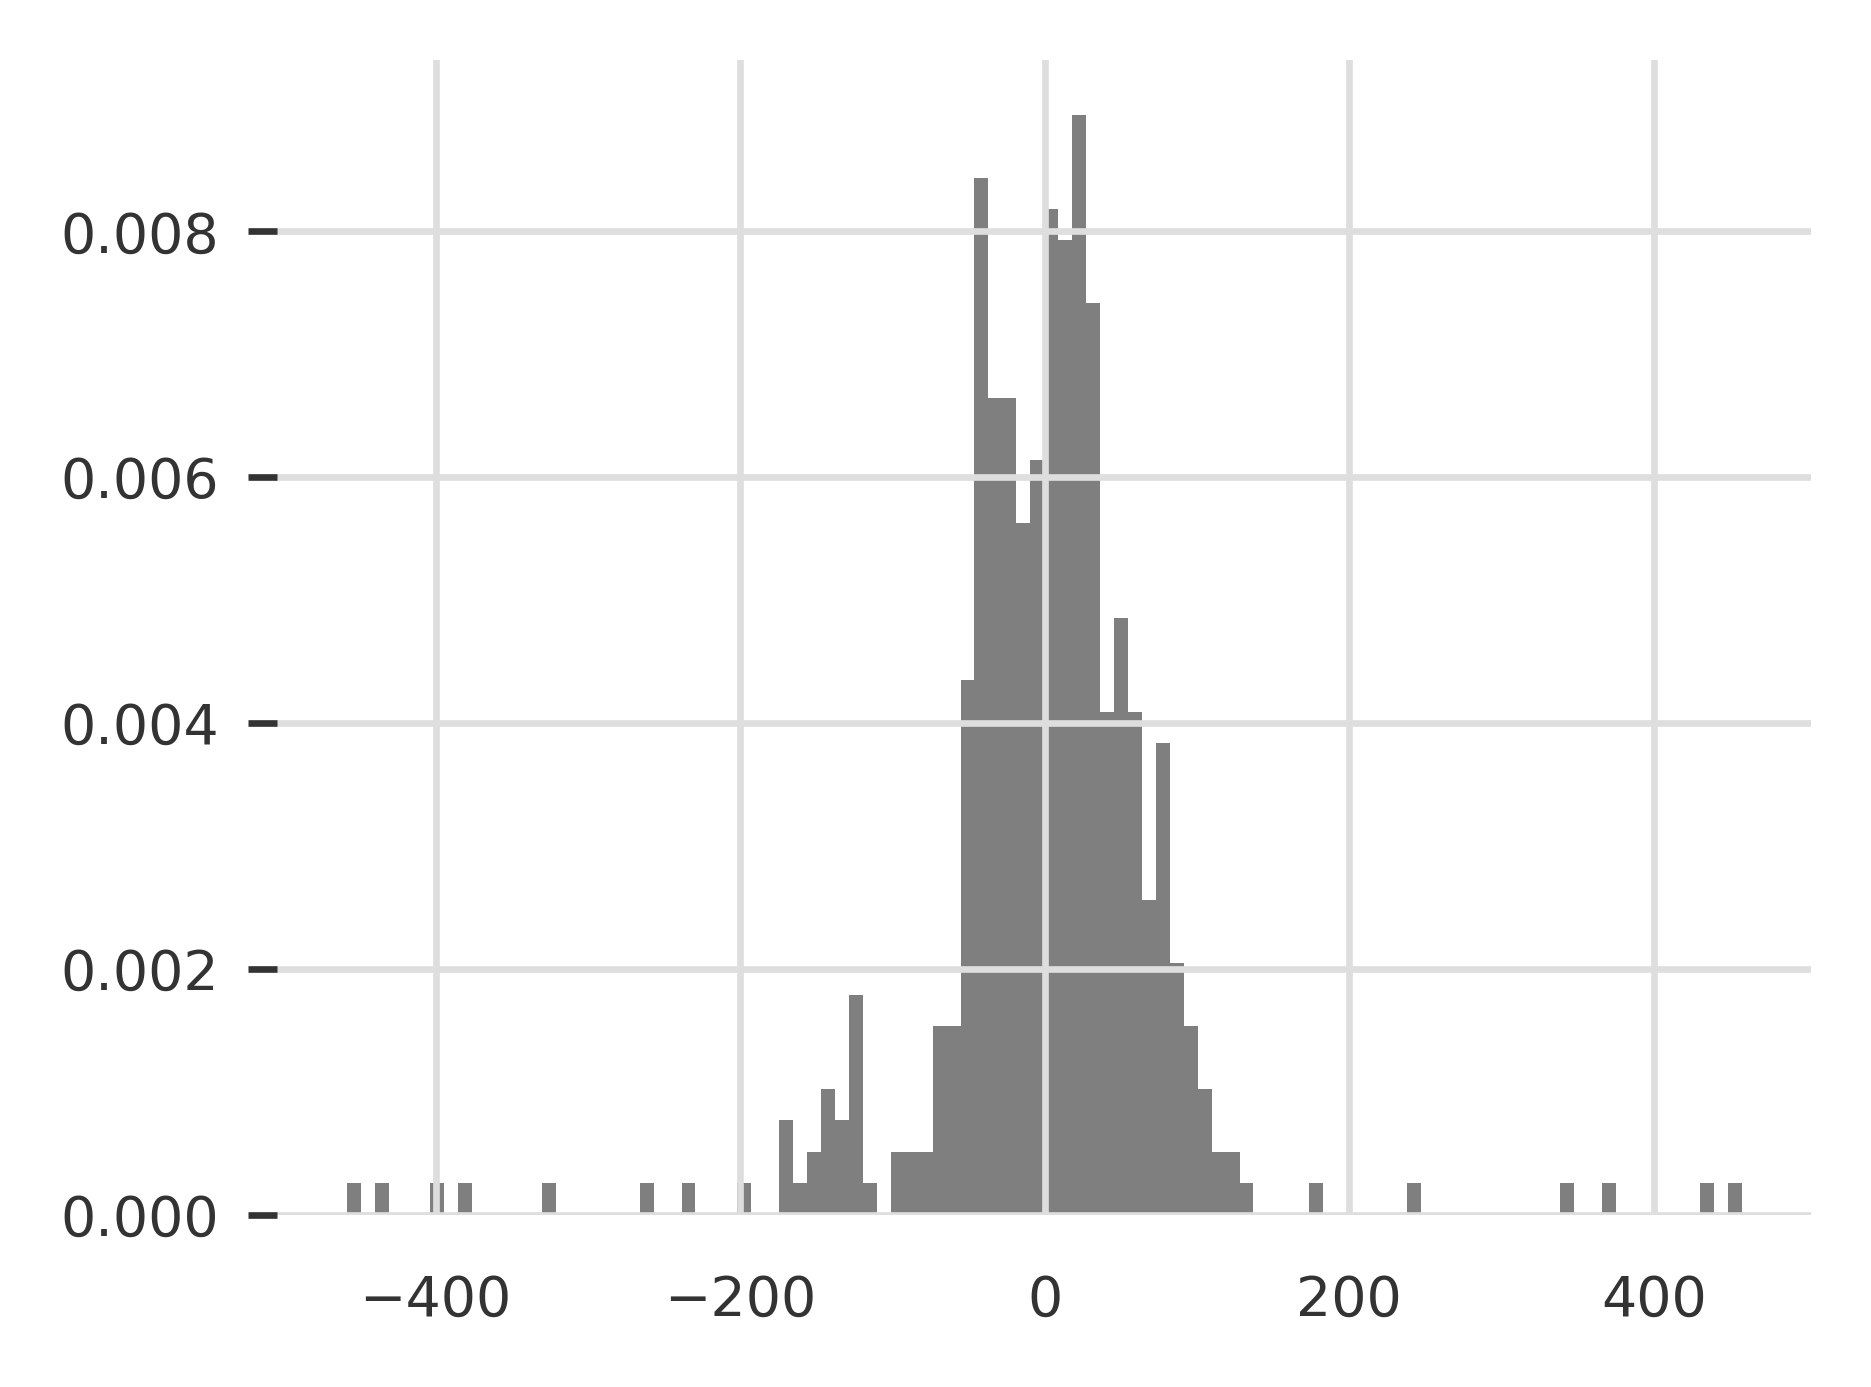

In [28]:
_ = plt.hist(results_df["residual"] - results_df["residual"].mean(), bins=100, density=True, alpha=0.5, label="Residuals")

In [ ]:
#results_df.to_parquet('aggregated_data_for_mpc.par')


In [21]:
results_df['residual'] = results_df['inflow'] - results_df['inflow_0.5']
results_df['date'] = results_df.index.date
grouped = results_df.groupby('date')['residual'].apply(list)
violin_data = grouped.values
violin_labels = [d.strftime('%d/%m') for d in grouped.index]

In [ ]:
mask = (results_df.index >= "2023-02-17 14:00:00+00:00") & (results_df.index <= "2023-02-17 18:00:00+00:00")
#results_df.loc[mask, 'inflow_0.1'] = results_df.loc[mask, 'inflow_0.1'] - 100
#results_df.loc[mask, 'inflow_0.9'] = results_df.loc[mask, 'inflow_0.9'] + 350

/tmp/ipykernel_403204/4292266145.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc="upper left")
/tmp/ipykernel_403204/4292266145.py:82: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend(loc='upper right')
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic

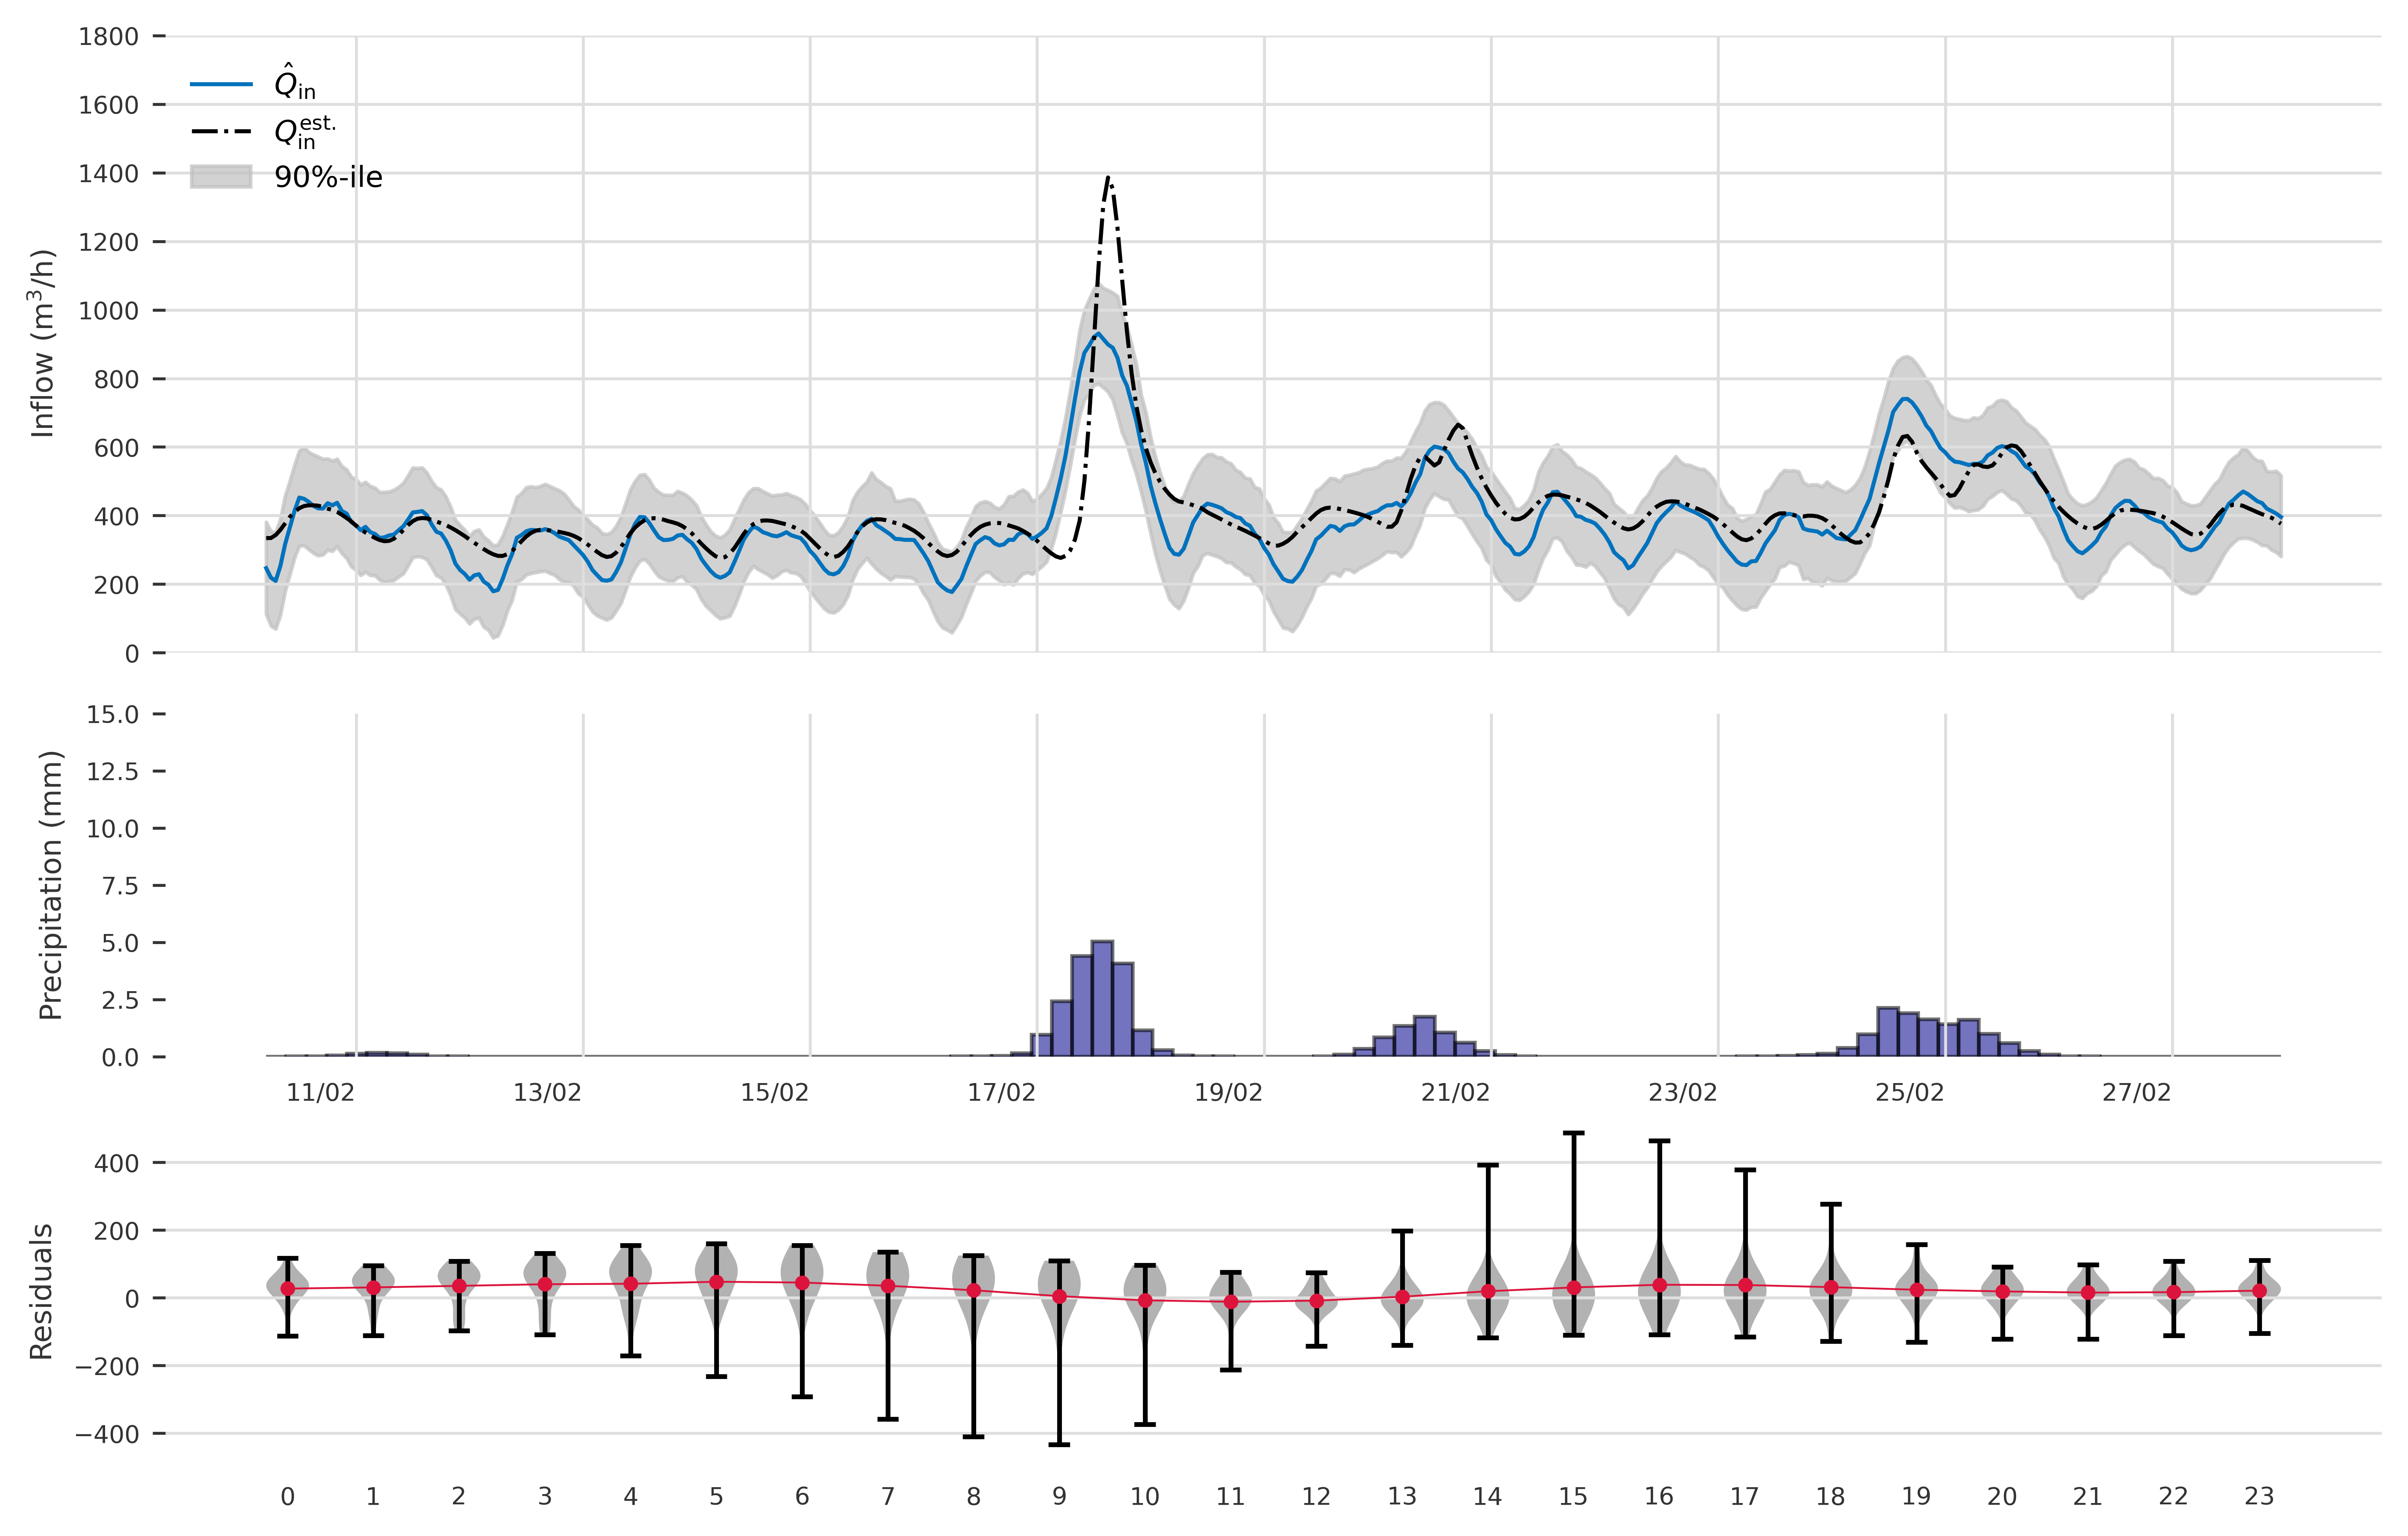

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.dates import DateFormatter

LINEWIDTH = 1.1
LABELPAD = 5

results_df['residual'] = results_df['inflow'] - results_df['inflow_0.5']
results_df['hour'] = results_df.index.hour

grouped = results_df.groupby('hour')['residual'].apply(list)
violin_data = grouped.values 
hours = np.array(grouped.index)

hour_means = [np.mean(v) for v in violin_data]

fig = plt.figure(figsize=(12, 6))
gs = GridSpec(nrows=3, ncols=1, height_ratios=[1.8, 1, 1], hspace=0.14)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax3 = fig.add_subplot(gs[2, 0])

ax1.plot(
    results_df.index, results_df["inflow_0.5"],
    color="#0072BD", 
    linestyle="-", 
    linewidth=LINEWIDTH,
    label=r'$\hat{Q}_{\text{in}}$'
)
ax1.plot(
    results_df.index, results_df["inflow"],
    linestyle="-.", 
    color="#000000", 
    linewidth=LINEWIDTH,
    label=r'$Q^\mathrm{est.}_{\text{in}}$'
)
ax1.fill_between(
    results_df.index, results_df["inflow_0.1"], results_df["inflow_0.9"],
    color='silver', 
    alpha=0.7, label=r'90%-ile'
)
ax1.set_ylabel(r'Inflow ($\mathrm{m}^3/\mathrm{h}$)', labelpad=LABELPAD, fontweight="normal")
ax1.set_ylim((0, 1800))
ax1.grid(True)
ax1.legend(loc="upper left")

ax2.hist(
    results_df.index,
    weights=results_df["precip_past1min"],
    bins=100,
    color="darkblue",
    alpha=0.55,
    orientation='vertical',
    edgecolor="black"
)
ax2.set_ylabel(r'Precipitation (mm)', labelpad=LABELPAD, fontweight="normal")
ax2.set_ylim((0, 15))
ax2.grid(axis='y')
ax2.legend(loc="upper left")
ax2.xaxis.set_major_formatter(DateFormatter('%d/%m'))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0, ha='right')
plt.setp(ax1.get_xticklabels(), visible=False)

positions = hours
vp = ax3.violinplot(
    violin_data,
    positions=positions,
    showmeans=False,
    showmedians=False,
    showextrema=True
)
ax3.set_ylabel('Residuals', labelpad=LABELPAD)
ax3.set_xticks(hours)
ax3.set_xticklabels(hours.astype(str), rotation=0, ha='center')
ax3.grid(axis='x')

ax3.plot(positions, hour_means, color='crimson', marker='o', linestyle='-', lw=0.5,markersize=3)
ax3.set_ylabel('Residuals', fontweight='normal')
ax3.legend(loc='upper right')

plt.subplots_adjust(right=0.85, left=0.15, top=0.95, bottom=0.05)
plt.show()

In [ ]:
results_df = results_df[21:]

In [ ]:
results_df = results_df[19 + 24*3:-24]

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


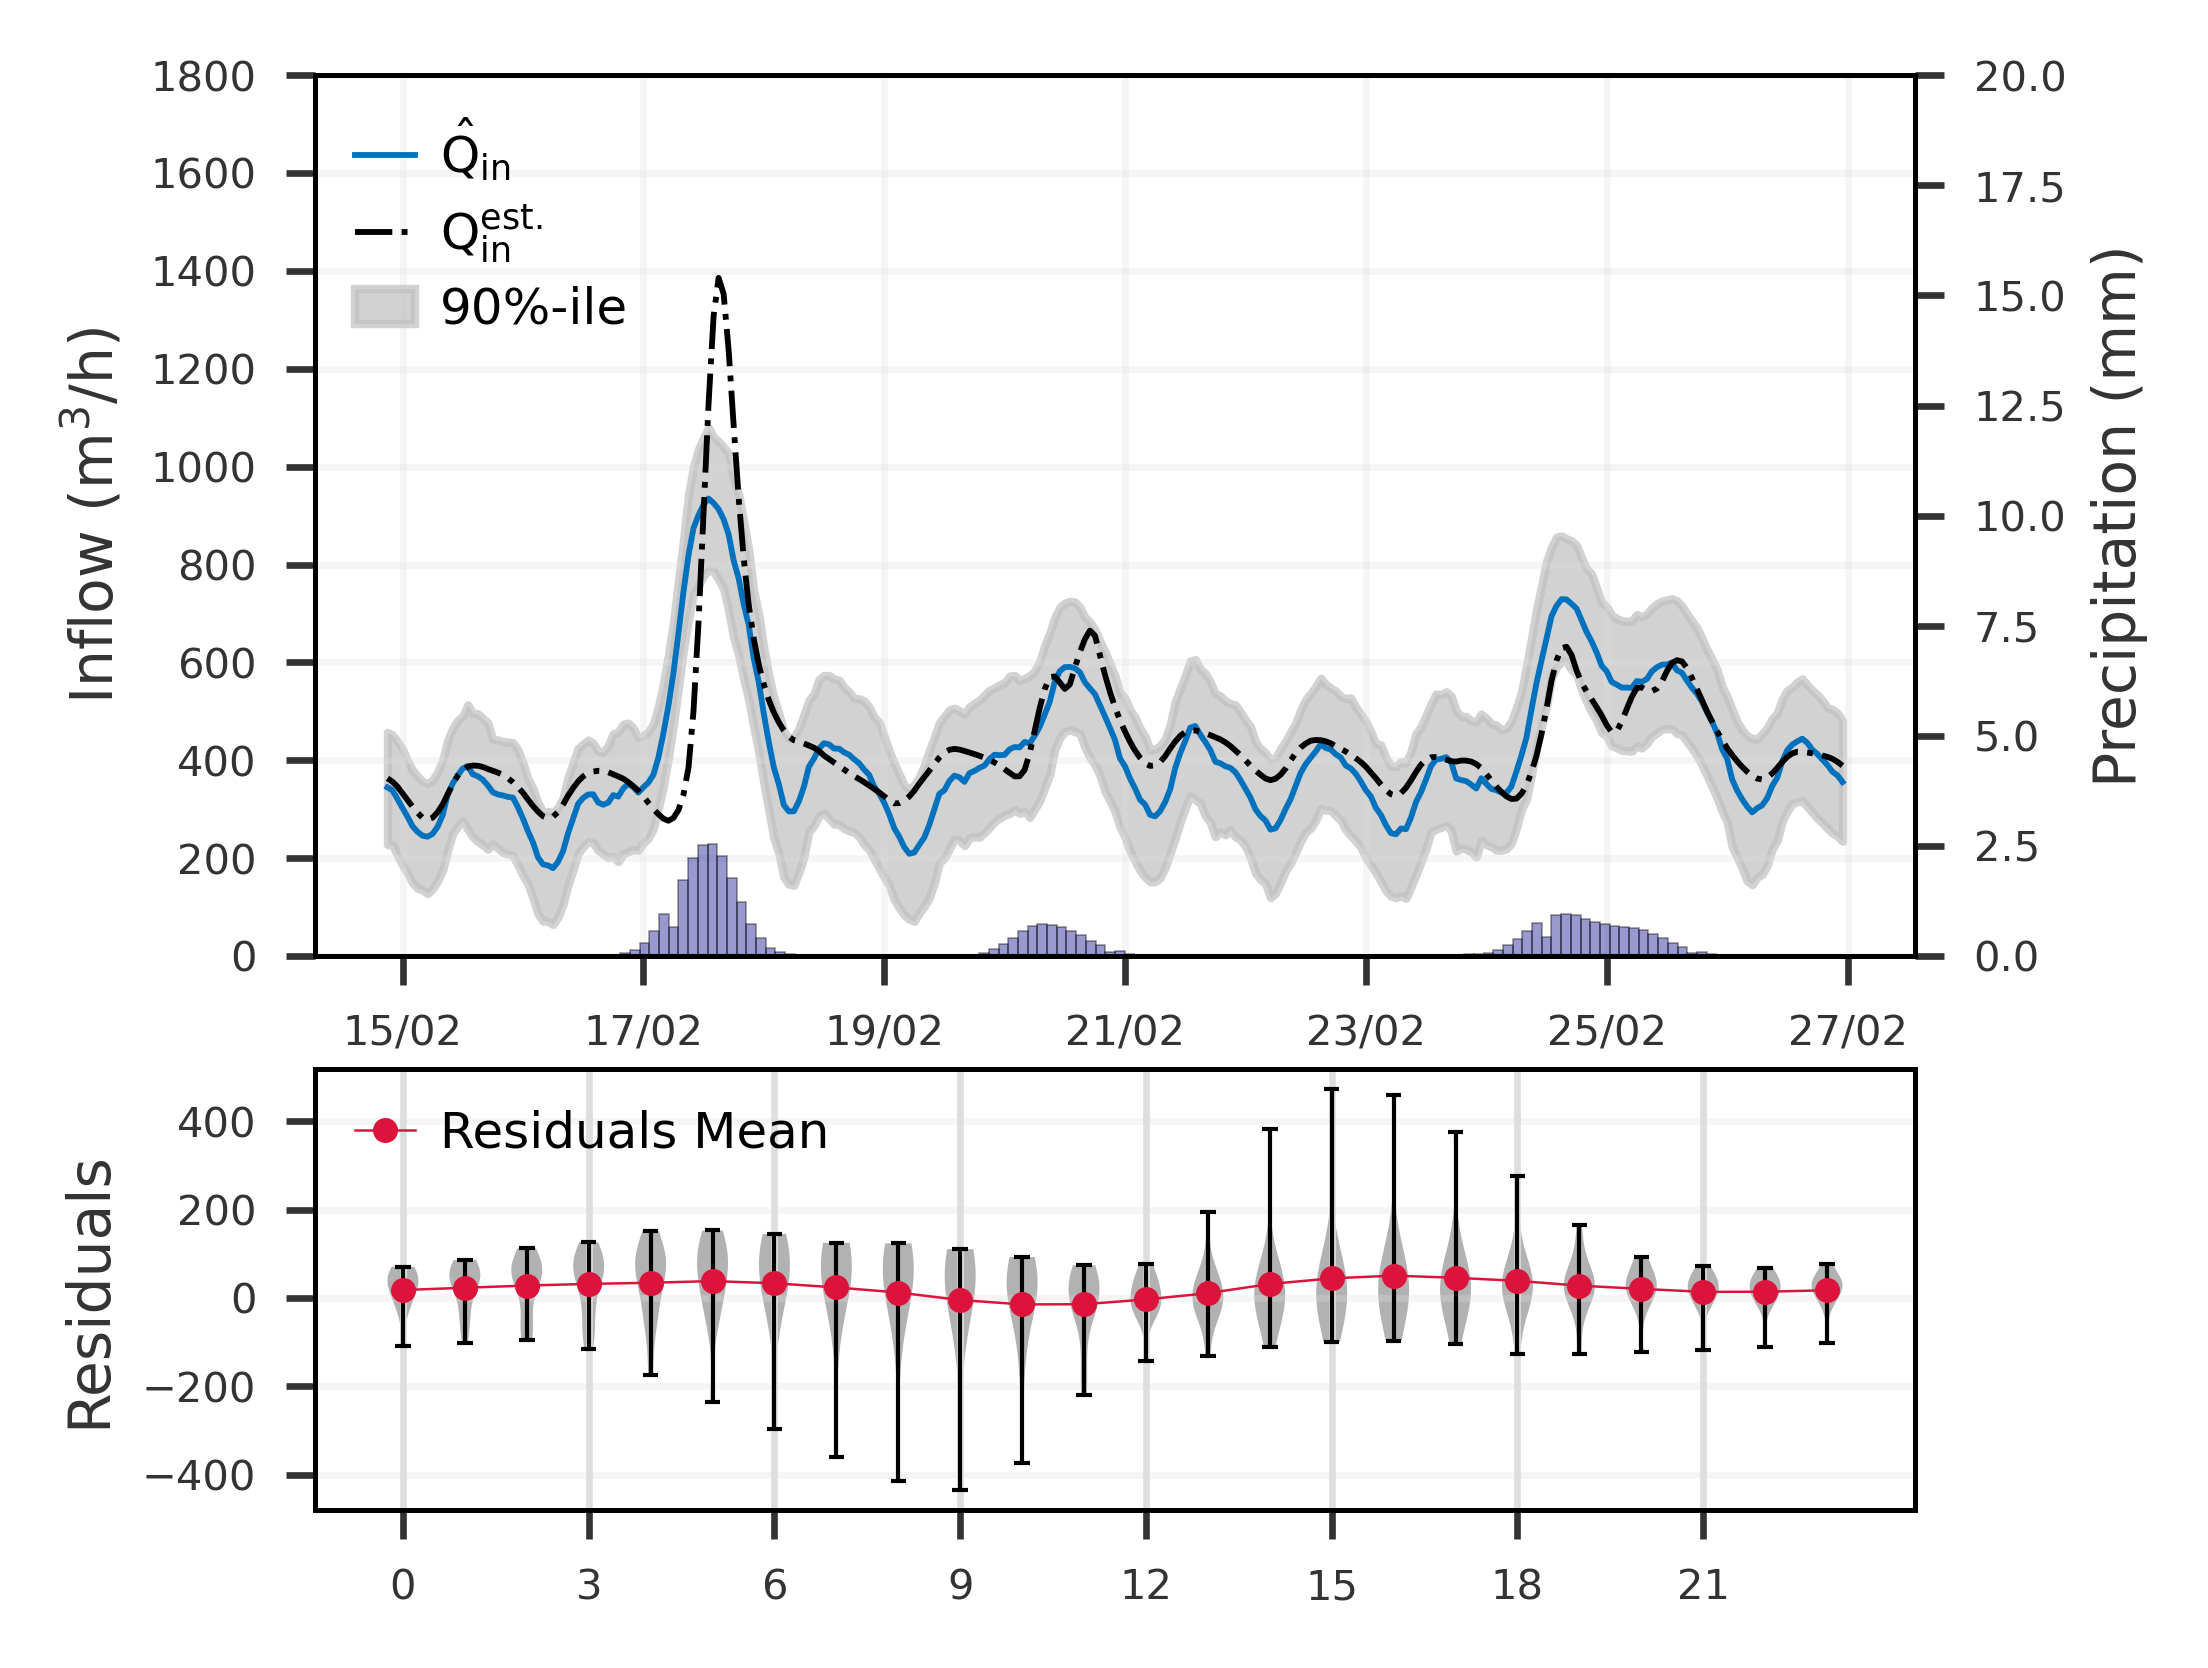

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

#=======================================#
#         GLOBAL FIGURE STYLE           #
#=======================================#
# --------- Figure font/style ----------
FONT_SIZE_LABEL    = 7
FONT_SIZE_TITLE    = 7
FONT_SIZE_TICKS    = 5
FONT_SIZE_LEGEND   = 6
FONT_SIZE_XLABEL   = 6  
AXIS_LABEL_WEIGHT  = 'normal'
LINEWIDTH          = 0.7
LABELPAD           = 3
MARKERSIZE         = 2

LEGEND_PARAMS = dict(
    fontsize=FONT_SIZE_LEGEND,
    frameon=False, fancybox=False,
    edgecolor='black', framealpha=1,
    handlelength=1.2, handletextpad=0.5, borderpad=0.4,
    labelspacing=0.4, borderaxespad=0.4
)

COLOR_INFLOW       = "#0072BD"
COLOR_INFLOW_EST   = "#000000"
COLOR_QUANTILE     = "silver"
COLOR_PRECIP       = "darkblue"
COLOR_MEAN         = "crimson"

# ---------- Matplotlib rcparams ----------
plt.rcParams.update({
    'font.size': FONT_SIZE_LABEL,
    'axes.labelsize': FONT_SIZE_LABEL,
    'axes.labelweight': AXIS_LABEL_WEIGHT,
    'axes.titlesize': FONT_SIZE_TITLE,
    'xtick.labelsize': FONT_SIZE_TICKS,
    'ytick.labelsize': FONT_SIZE_TICKS,
    'legend.fontsize': FONT_SIZE_LEGEND,
    'lines.linewidth': 1,
    'lines.markersize': MARKERSIZE,
})


#===========================#
#   DATA PREPARATION        #
#===========================#
# Example: results_df must already exist and have datetime index, and required columns

results_df['residual'] = results_df['inflow'] - results_df['inflow_0.5']
results_df['hour'] = results_df.index.hour

grouped = results_df.groupby('hour')['residual'].apply(list)
violin_data = grouped.values 
hours = np.array(grouped.index)
hour_means = [np.mean(v) for v in violin_data]

#===========================#
#       PLOTTING            #
#===========================#
fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(3.5, 2.6),
    gridspec_kw=dict(height_ratios=[2, 1])
)

#==== Top panel: Inflow lines & precip (twin axis) ====
ax1b = ax1.twinx()
ax1b.hist(
    results_df.index,
    weights=results_df["precip_past1min"],
    bins=150,
    color=COLOR_PRECIP,
    alpha=0.4,
    edgecolor='black',
    linewidth=0.2,
    label="Precipitation",
    orientation='vertical'
)
ax1.plot(
    results_df.index,
    results_df["inflow_0.5"],
    color=COLOR_INFLOW,
    lw=LINEWIDTH,
    label=r'$\hat{\text{Q}}_{\text{in}}$',
    zorder=2
)
ax1.plot(
    results_df.index,
    results_df["inflow"],
    color=COLOR_INFLOW_EST,
    ls="-.",
    lw=LINEWIDTH,
    label=r'$\text{Q}^\mathrm{est.}_{\text{in}}$',
    zorder=3
)
ax1.fill_between(
    results_df.index,
    results_df["inflow_0.1"],
    results_df["inflow_0.9"],
    color=COLOR_QUANTILE,
    alpha=0.7,
    label="90%-ile",
    zorder=0
)
ax1.set_ylabel(r'Inflow ($\mathrm{m}^3/\mathrm{h}$)', labelpad=LABELPAD, fontweight=AXIS_LABEL_WEIGHT)
ax1.set_ylim((0, 1800))
ax1.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax1.grid(True, zorder=0, alpha=0.3)
ax1.legend(loc="upper left", **LEGEND_PARAMS)

ax1b.set_ylabel('Precipitation (mm)', labelpad=LABELPAD, fontweight=AXIS_LABEL_WEIGHT)
ax1b.set_ylim((0, 20))
ax1b.grid(False)
ax1b.tick_params(axis='y', labelsize=FONT_SIZE_TICKS)
ax1.xaxis.set_major_formatter(DateFormatter('%d/%m'))
plt.setp(ax1.xaxis.get_majorticklabels(), visible=True)

#==== Bottom panel: Violin plot of hourly residuals ====
parts = ax2.violinplot(
    violin_data,
    positions=hours,
    showmeans=False,
    showmedians=False,
    showextrema=True
)



for key in ['cmaxes', 'cmins', 'cbars']:
    if key in parts:
        parts[key].set_linewidth(0.5)
        parts[key].set_color('black')
ax2.set_ylabel('Residuals', labelpad=LABELPAD, fontweight=AXIS_LABEL_WEIGHT)

# Ensure last hour always present in xticks
xtick_hours = hours[::3] if len(hours) > 10 else hours
ax2.set_xticks(xtick_hours)
ax2.set_xticklabels(xtick_hours.astype(str), ha='center', fontsize=FONT_SIZE_TICKS)

ax2.grid(axis='y', alpha=0.3)
ax2.plot(
    hours, hour_means, color=COLOR_MEAN, marker='o',
    linestyle='-', lw=0.3, markersize=MARKERSIZE, label='Residuals Mean'
)
ax2.legend(loc='upper left', **LEGEND_PARAMS)
ax2.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)

for ax in [ax1, ax2, ax1b]:
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.6)  # adjust if needed

plt.tight_layout(pad=0.1)
#plt.savefig('inflow_forecast.pdf', format='pdf', dpi=600, bbox_inches='tight')
plt.show()